<a href="https://colab.research.google.com/github/Kiarashmo/Stroke-Patient-Motor-Imagery-Classification-System-by-Utilizing-Transfer-Learning/blob/main/Stroke_Dataset_Data_Loading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dependencies

In [ ]:
!pip install mne
!pip install torcheeg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 73.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.1/161.1 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.2/299.2 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.8/230.8 kB 27.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 729.2/729.2 kB 42.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.1/71.1 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 79.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.7/55.7 kB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 78.6 MB/s eta 0:00:00
  Created wheel for torcheeg: filename=torcheeg-1.0.11-py3-none-any.whl siz

##Importing necessary packages

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import torcheeg
import mne
import scipy
import scipy.io
import matplotlib.pyplot as plt

In [ ]:
strokeDataset_path = '/content/drive/MyDrive/NMA2023_DL/Stroke_Dataset'
stroke_raw_data_path = f'{strokeDataset_path}/edffile/'
stroke_raw_data_path2 = f'{strokeDataset_path}/code/sourcedata/'
processed_data_path = f'{strokeDataset_path}/mi_channels'

##Data Loading

In [ ]:
mi_related_channels = [
 'F7',
 'F3',
 'Fz',
 'F4',
 'F8',
 'FT7',
 'FC3',
 'FCz',
 'FC4',
 'FT8',
 'T3',
 'T4',
 'TP7',
 'TP8',
 'CP3',
 'CP4',
 'C3',
 'C4',
 'Cz',
]

In [ ]:
events_file = f'{strokeDataset_path}/task-motor-imagery_events.tsv'

In [ ]:
import pandas as pd

events_data = pd.read_csv(events_file, sep="\t")
wanted_trials = events_data[events_data["value"] == 2]

trial_labels = []
for i, w in wanted_trials.iterrows():
  label = w["trial_type"]
  trial_labels.append(label)
  # print(start, end, label)
print(len(trial_labels))

40


In [ ]:
import numpy as np
from scipy import signal
from mne import filter


OLD_SAMPLING_FREQUENCY =500
SAMPLING_FREQUENCY = 160

TIME_WINDOW_S = 4
SAMPLING_WINDOW = SAMPLING_FREQUENCY * TIME_WINDOW_S

OVERLAPPING_TIME_WINDOW_S = 0
OVERLAPPING_SAMPLES = int(SAMPLING_FREQUENCY * OVERLAPPING_TIME_WINDOW_S)

LEN_TRIALS = 4000

for i in range(1, 51):
  dataset = []
  labels = []

  trial_path = f'{stroke_raw_data_path}/sub-{i:02}/eeg/sub-{i:02}_task-motor-imagery_eeg.edf'

  if mi_related_channels:
    edf_data = mne.io.read_raw_edf(trial_path, verbose='WARNING', include=mi_related_channels, preload=True)
    edf_data.reorder_channels(mi_related_channels)
  else:
    edf_data = mne.io.read_raw_edf(trial_path, verbose='WARNING', preload=True)

  edf_data.set_eeg_reference('average')

  data = edf_data.get_data()
  print(data.shape)
  datas = []

  datas = np.split(data, data.shape[1] // LEN_TRIALS, axis=1)

  for j, trial_data in enumerate(datas):
    # Change sample frequency
    resample_points = int(SAMPLING_FREQUENCY/OLD_SAMPLING_FREQUENCY * trial_data.shape[1])
    trial_data = signal.resample(trial_data, resample_points, axis=1)
    # print("trial_data shape after resampling:", trial_data.shape)

    datas[j] = trial_data

  datas = np.array(datas)

  low_freq_cutoff = 0.5
  high_freq_cutoff = 79
  datas = filter.filter_data(datas, SAMPLING_FREQUENCY, low_freq_cutoff, high_freq_cutoff)


  for k, label in enumerate(trial_labels):
    # Split into smaller windows
    break_points = list(range(0, datas[k].shape[1], SAMPLING_WINDOW-OVERLAPPING_SAMPLES))

    for break_point in break_points:
      if break_point+SAMPLING_WINDOW > datas[k].shape[1]:
        continue
      one_split = np.take(datas[k], range(break_point, break_point+SAMPLING_WINDOW), axis=1)

      # Append each split and corresponding label to data
      dataset.append(one_split)
      labels.append(0 if label == 2 else 1) # convert labels to 0 and 1

  dataset = np.array(dataset)
  labels = np.array(labels)
  print(dataset.shape)
  print(labels.shape)

  # Store data and labels in file

  data_path = f'{processed_data_path}/Filtered/subject{i:03}.npz'
  np.savez(data_path, data=dataset, labels=labels)
  print(f'---------S{i:03} trials saved---------')

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
(19, 160000)
Setting up band-pass filter from 0.5 - 79 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 79.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 79.50 Hz)
- Filter length: 1057 samples (6.606 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.2s


(80, 19, 640)
(80,)
---------S001 trials saved---------
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
(19, 160000)
Setting up band-pass filter from 0.5 - 79 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 79.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 79.50 Hz)
- Filter length: 1057 samples (6.606 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.3s


(80, 19, 640)
(80,)
---------S002 trials saved---------
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
(19, 160000)
Setting up band-pass filter from 0.5 - 79 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 79.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 79.50 Hz)
- Filter length: 1057 samples (6.606 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.3s


(80, 19, 640)
(80,)
---------S003 trials saved---------
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
(19, 160000)
Setting up band-pass filter from 0.5 - 79 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 79.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 79.50 Hz)
- Filter length: 1057 samples (6.606 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.2s


(80, 19, 640)
(80,)
---------S004 trials saved---------
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
(19, 160000)
Setting up band-pass filter from 0.5 - 79 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 79.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 79.50 Hz)
- Filter length: 1057 samples (6.606 s)

(80, 19, 640)
(80,)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.1s


---------S005 trials saved---------
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
(19, 160000)
Setting up band-pass filter from 0.5 - 79 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 79.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 79.50 Hz)
- Filter length: 1057 samples (6.606 s)

(80, 19, 640)
(80,)
---------S006 trials saved---------


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.2s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
(19, 160000)
Setting up band-pass filter from 0.5 - 79 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 79.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 79.50 Hz)
- Filter length: 1057 samples (6.606 s)

(80, 19, 640)
(80,)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.1s


---------S007 trials saved---------
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
(19, 160000)
Setting up band-pass filter from 0.5 - 79 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 79.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 79.50 Hz)
- Filter length: 1057 samples (6.606 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.1s


(80, 19, 640)
(80,)
---------S008 trials saved---------
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
(19, 160000)
Setting up band-pass filter from 0.5 - 79 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 79.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 79.50 Hz)
- Filter length: 1057 samples (6.606 s)

(80, 19, 640)
(80,)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.1s


---------S009 trials saved---------
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
(19, 160000)
Setting up band-pass filter from 0.5 - 79 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 79.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 79.50 Hz)
- Filter length: 1057 samples (6.606 s)

(80, 19, 640)
(80,)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.1s


---------S010 trials saved---------
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
(19, 160000)
Setting up band-pass filter from 0.5 - 79 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 79.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 79.50 Hz)
- Filter length: 1057 samples (6.606 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.1s


(80, 19, 640)
(80,)
---------S011 trials saved---------
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
(19, 160000)
Setting up band-pass filter from 0.5 - 79 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 79.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 79.50 Hz)
- Filter length: 1057 samples (6.606 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.3s


(80, 19, 640)
(80,)
---------S012 trials saved---------
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
(19, 160000)
Setting up band-pass filter from 0.5 - 79 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 79.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 79.50 Hz)
- Filter length: 1057 samples (6.606 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.3s


(80, 19, 640)
(80,)
---------S013 trials saved---------
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
(19, 160000)
Setting up band-pass filter from 0.5 - 79 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 79.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 79.50 Hz)
- Filter length: 1057 samples (6.606 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.2s


(80, 19, 640)
(80,)
---------S014 trials saved---------
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
(19, 160000)
Setting up band-pass filter from 0.5 - 79 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 79.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 79.50 Hz)
- Filter length: 1057 samples (6.606 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.2s


(80, 19, 640)
(80,)
---------S015 trials saved---------
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
(19, 160000)
Setting up band-pass filter from 0.5 - 79 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 79.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 79.50 Hz)
- Filter length: 1057 samples (6.606 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.1s


(80, 19, 640)
(80,)
---------S016 trials saved---------
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
(19, 160000)
Setting up band-pass filter from 0.5 - 79 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 79.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 79.50 Hz)
- Filter length: 1057 samples (6.606 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s


(80, 19, 640)
(80,)
---------S017 trials saved---------
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
(19, 160000)
Setting up band-pass filter from 0.5 - 79 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 79.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 79.50 Hz)
- Filter length: 1057 samples (6.606 s)



[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.2s


(80, 19, 640)
(80,)
---------S018 trials saved---------
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
(19, 160000)
Setting up band-pass filter from 0.5 - 79 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 79.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 79.50 Hz)
- Filter length: 1057 samples (6.606 s)

(80, 19, 640)
(80,)
---------S019 trials saved---------


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.2s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
(19, 160000)
Setting up band-pass filter from 0.5 - 79 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 79.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 79.50 Hz)
- Filter length: 1057 samples (6.606 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.2s


(80, 19, 640)
(80,)
---------S020 trials saved---------
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
(19, 160000)
Setting up band-pass filter from 0.5 - 79 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 79.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 79.50 Hz)
- Filter length: 1057 samples (6.606 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.2s


(80, 19, 640)
(80,)
---------S021 trials saved---------
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
(19, 160000)
Setting up band-pass filter from 0.5 - 79 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 79.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 79.50 Hz)
- Filter length: 1057 samples (6.606 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.2s


(80, 19, 640)
(80,)
---------S022 trials saved---------
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
(19, 160000)
Setting up band-pass filter from 0.5 - 79 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 79.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 79.50 Hz)
- Filter length: 1057 samples (6.606 s)

(80, 19, 640)
(80,)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.1s


---------S023 trials saved---------
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
(19, 160000)
Setting up band-pass filter from 0.5 - 79 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 79.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 79.50 Hz)
- Filter length: 1057 samples (6.606 s)

(80, 19, 640)
(80,)
---------S024 trials saved---------


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.1s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
(19, 160000)
Setting up band-pass filter from 0.5 - 79 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 79.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 79.50 Hz)
- Filter length: 1057 samples (6.606 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.1s


(80, 19, 640)
(80,)
---------S025 trials saved---------
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
(19, 160000)
Setting up band-pass filter from 0.5 - 79 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 79.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 79.50 Hz)
- Filter length: 1057 samples (6.606 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.3s


(80, 19, 640)
(80,)
---------S026 trials saved---------
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
(19, 160000)
Setting up band-pass filter from 0.5 - 79 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 79.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 79.50 Hz)
- Filter length: 1057 samples (6.606 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.2s


(80, 19, 640)
(80,)
---------S027 trials saved---------
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
(19, 160000)
Setting up band-pass filter from 0.5 - 79 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 79.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 79.50 Hz)
- Filter length: 1057 samples (6.606 s)

(80, 19, 640)
(80,)
---------S028 trials saved---------


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.1s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
(19, 160000)
Setting up band-pass filter from 0.5 - 79 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 79.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 79.50 Hz)
- Filter length: 1057 samples (6.606 s)

(80, 19, 640)
(80,)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.1s


---------S029 trials saved---------
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
(19, 160000)
Setting up band-pass filter from 0.5 - 79 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 79.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 79.50 Hz)
- Filter length: 1057 samples (6.606 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.1s


(80, 19, 640)
(80,)
---------S030 trials saved---------
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
(19, 160000)
Setting up band-pass filter from 0.5 - 79 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 79.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 79.50 Hz)
- Filter length: 1057 samples (6.606 s)

(80, 19, 640)
(80,)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.1s


---------S031 trials saved---------
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
(19, 160000)
Setting up band-pass filter from 0.5 - 79 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 79.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 79.50 Hz)
- Filter length: 1057 samples (6.606 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.2s


(80, 19, 640)
(80,)
---------S032 trials saved---------
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
(19, 160000)
Setting up band-pass filter from 0.5 - 79 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 79.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 79.50 Hz)
- Filter length: 1057 samples (6.606 s)

(80, 19, 640)
(80,)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.1s


---------S033 trials saved---------
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
(19, 160000)
Setting up band-pass filter from 0.5 - 79 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 79.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 79.50 Hz)
- Filter length: 1057 samples (6.606 s)

(80, 19, 640)
(80,)
---------S034 trials saved---------


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.2s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
(19, 160000)
Setting up band-pass filter from 0.5 - 79 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 79.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 79.50 Hz)
- Filter length: 1057 samples (6.606 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.2s


(80, 19, 640)
(80,)
---------S035 trials saved---------
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
(19, 160000)
Setting up band-pass filter from 0.5 - 79 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 79.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 79.50 Hz)
- Filter length: 1057 samples (6.606 s)

(80, 19, 640)
(80,)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.1s


---------S036 trials saved---------
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
(19, 160000)
Setting up band-pass filter from 0.5 - 79 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 79.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 79.50 Hz)
- Filter length: 1057 samples (6.606 s)

(80, 19, 640)
(80,)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.1s


---------S037 trials saved---------
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
(19, 160000)
Setting up band-pass filter from 0.5 - 79 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 79.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 79.50 Hz)
- Filter length: 1057 samples (6.606 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.3s


(80, 19, 640)
(80,)
---------S038 trials saved---------
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
(19, 160000)
Setting up band-pass filter from 0.5 - 79 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 79.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 79.50 Hz)
- Filter length: 1057 samples (6.606 s)

(80, 19, 640)
(80,)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.1s


---------S039 trials saved---------
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
(19, 160000)
Setting up band-pass filter from 0.5 - 79 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 79.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 79.50 Hz)
- Filter length: 1057 samples (6.606 s)

(80, 19, 640)
(80,)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.1s


---------S040 trials saved---------
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
(19, 160000)
Setting up band-pass filter from 0.5 - 79 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 79.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 79.50 Hz)
- Filter length: 1057 samples (6.606 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.2s


(80, 19, 640)
(80,)
---------S041 trials saved---------
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
(19, 160000)
Setting up band-pass filter from 0.5 - 79 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 79.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 79.50 Hz)
- Filter length: 1057 samples (6.606 s)

(80, 19, 640)
(80,)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.1s


---------S042 trials saved---------
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
(19, 160000)
Setting up band-pass filter from 0.5 - 79 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 79.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 79.50 Hz)
- Filter length: 1057 samples (6.606 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s


(80, 19, 640)
(80,)
---------S043 trials saved---------
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
(19, 160000)
Setting up band-pass filter from 0.5 - 79 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 79.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 79.50 Hz)
- Filter length: 1057 samples (6.606 s)



[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.3s


(80, 19, 640)
(80,)
---------S044 trials saved---------
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
(19, 160000)
Setting up band-pass filter from 0.5 - 79 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 79.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 79.50 Hz)
- Filter length: 1057 samples (6.606 s)

(80, 19, 640)
(80,)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.2s


---------S045 trials saved---------
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
(19, 160000)
Setting up band-pass filter from 0.5 - 79 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 79.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 79.50 Hz)
- Filter length: 1057 samples (6.606 s)

(80, 19, 640)
(80,)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.2s


---------S046 trials saved---------
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
(19, 160000)
Setting up band-pass filter from 0.5 - 79 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 79.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 79.50 Hz)
- Filter length: 1057 samples (6.606 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.2s


(80, 19, 640)
(80,)
---------S047 trials saved---------
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
(19, 160000)
Setting up band-pass filter from 0.5 - 79 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 79.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 79.50 Hz)
- Filter length: 1057 samples (6.606 s)

(80, 19, 640)
(80,)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.2s


---------S048 trials saved---------
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
(19, 160000)
Setting up band-pass filter from 0.5 - 79 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 79.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 79.50 Hz)
- Filter length: 1057 samples (6.606 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.2s


(80, 19, 640)
(80,)
---------S049 trials saved---------
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
(19, 160000)
Setting up band-pass filter from 0.5 - 79 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 79.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 79.50 Hz)
- Filter length: 1057 samples (6.606 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.2s


(80, 19, 640)
(80,)
---------S050 trials saved---------


[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.3s


In [ ]:
edf_data.describe()

<RawEDF | sub-50_task-motor-imagery_eeg.edf, 19 x 160000 (320.0 s), ~23.2 MB, data loaded>
ch  name  type  unit        min         Q1     median         Q3        max
 0  F7    EEG   µV       -63.57      -9.10      -1.04       6.24     115.48
 1  F3    EEG   µV      -122.64     -11.64       0.41      11.27     141.16
 2  Fz    EEG   µV      -171.07      -9.20       1.55      13.96     106.38
 3  F4    EEG   µV       -76.06      -5.77       0.50       6.60      49.92
 4  F8    EEG   µV      -246.12      -8.74      -0.49       7.09     130.23
 5  FT7   EEG   µV       -66.84      -6.82      -0.32       5.97     123.17
 6  FC3   EEG   µV       -71.31      -5.71       0.68       6.82      80.46
 7  FCz   EEG   µV      -175.65      -7.19       1.54      12.25     105.88
 8  FC4   EEG   µV      -126.69      -8.38       0.84       9.25     126.20
 9  FT8   EEG   µV      -220.19      -9.62      -0.58       6.76     232.45
10  T3    EEG   µV       -89.07      -6.71       0.23       7.21      98.

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


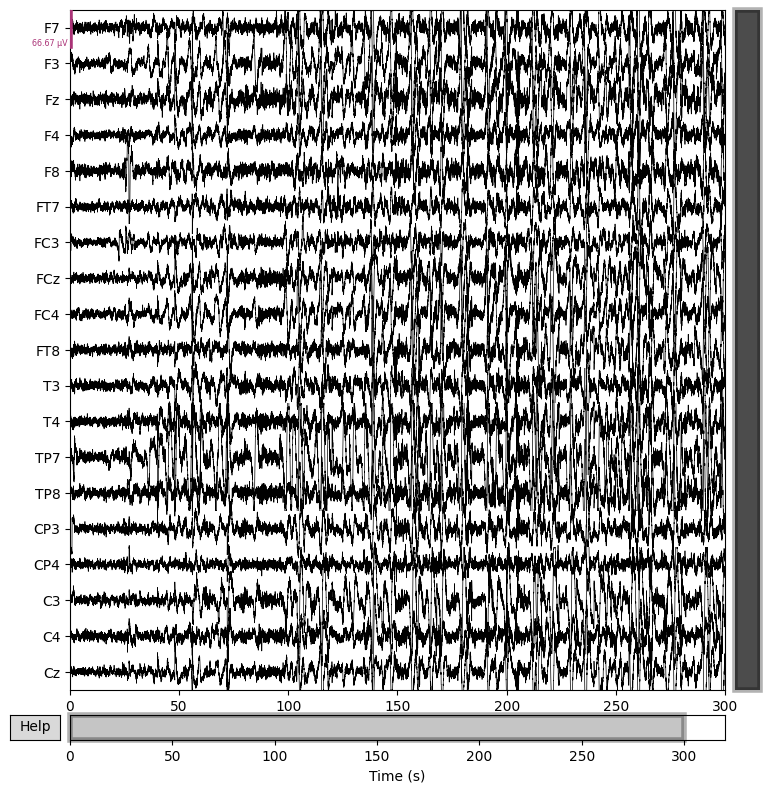

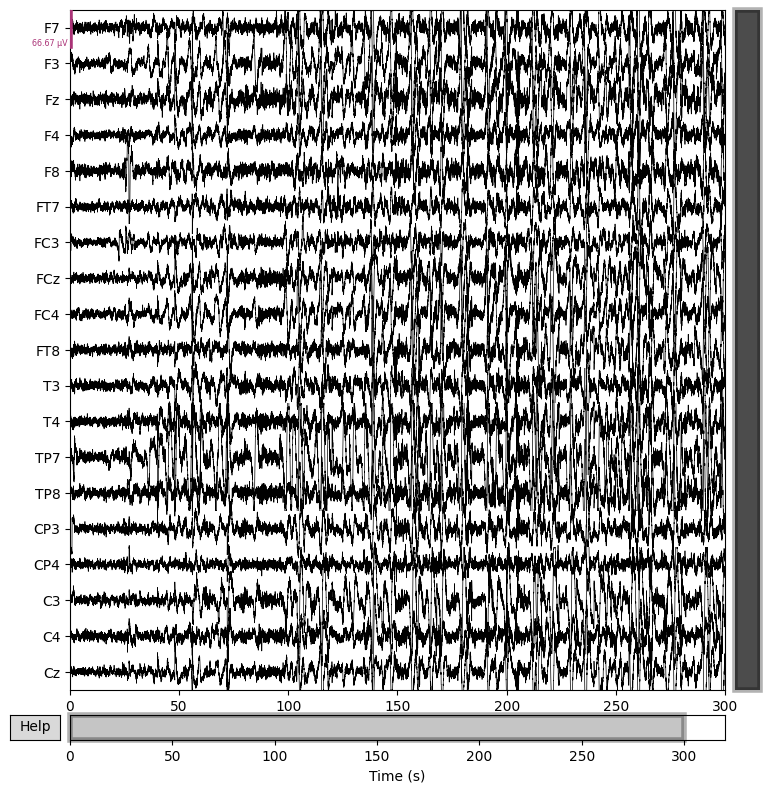

In [ ]:
edf2_data = edf_data.copy().set_eeg_reference(ref_channels='average')
edf2_data.plot(start=0, duration=300,scalings=1e-4/3, title='Stroke dataset')